# Imports

In [3]:
!pip install folium

import numpy as np 
import pandas as pd
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests # library to handle requests
# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library
import seaborn as sns
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [5]:
toronto_data_w_gsptl = pd.read_csv('toronto_data_w_gsptl.csv')

In [7]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET = # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


In [8]:
toronto_data_w_gsptl.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [9]:
toronto_data_w_gsptl.drop(columns = 'Postcode',inplace=True)
print(print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_data_w_gsptl['Borough'].unique()),
        toronto_data_w_gsptl.shape[0])))
toronto_data_w_gsptl.head()

The dataframe has 11 boroughs and 103 neighborhoods.
None


,Borough,Neighbourhood,Latitude,Longitude
0,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,Scarborough,Woburn,43.770992,-79.216917
4,Scarborough,Cedarbrae,43.773136,-79.239476


#### Create a map of Toronto 

In [10]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[toronto_data_w_gsptl.Latitude.mean(),
                                   toronto_data_w_gsptl.Longitude.mean()], zoom_start=10)

# add markers to map
iterator = zip(toronto_data_w_gsptl['Latitude'], toronto_data_w_gsptl['Longitude'],
                toronto_data_w_gsptl['Borough'], toronto_data_w_gsptl['Neighbourhood'])
for lat, lng, borough, neighborhood in iterator:
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

Well that is most certainly cool!! Folium is the best.

## Explore Neighborhoods in Toronto

#### Let's create a function to repeat the same process to all the neighborhoods in Manhattan

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT=100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        while True:
            try:
                results = requests.get(url).json()["response"]['groups'][0]['items']
                break
            except:
                continue
            
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
# toronto_venues = getNearbyVenues(names=toronto_data_w_gsptl['Neighbourhood'],
#                                    latitudes=toronto_data_w_gsptl['Latitude'],
#                                    longitudes=toronto_data_w_gsptl['Longitude']
#                                   )
##Checkpoint
# toronto_venues.to_csv('toronto_venues.csv', index=False)

In [8]:
toronto_venues = pd.read_csv('toronto_venues.csv')

In [9]:
print(toronto_venues.shape)
toronto_venues.head()

(2259, 7)


,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge, Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,Affordable Toronto Movers,43.787919,-79.162977,Moving Target
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


Let's check how many venues were returned for each neighborhood

In [10]:
venue_counts = toronto_venues.groupby('Neighborhood').Venue.count()
venue_counts

Neighborhood
Adelaide, King, Richmond                                                                                                                  100
Agincourt                                                                                                                                   4
Agincourt North, L'Amoreaux East, Milliken, Steeles East                                                                                    2
Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown                              11
Alderwood, Long Branch                                                                                                                      8
Bathurst Manor, Downsview North, Wilson Heights                                                                                            18
Bayview Village                                                                                                                        

it looks like we have a lot of neighborhoods that have less than 100 venues.

So let's look at the distribution

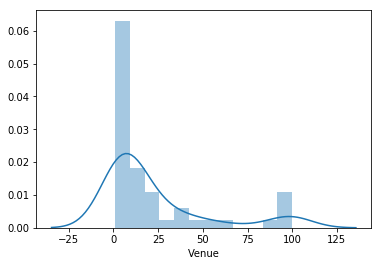

In [11]:
sns.distplot(venue_counts);

Let's look at how many neighboorhoods have more than 75% 

In [12]:
print(f"""The're is only {len(venue_counts[venue_counts>=75.0])/len(venue_counts)*100}% of the neighbourhoods with more than 75 venues
The number of these neighbourhoods is {len(venue_counts[venue_counts>=75.0])}""")

The're is only 11.0% of the neighbourhoods with more than 75 venues
The number of these neighbourhoods is 11


Let's look at how many neighboorhoods have more than 25% 

In [13]:
print(f"""The're is only {len(venue_counts[venue_counts>=25.0])/len(venue_counts)*100}% of the neighbourhoods with more than 75 venues
The number of these neighbourhoods is {len(venue_counts[venue_counts>=25.0])}""")

The're is only 25.0% of the neighbourhoods with more than 75 venues
The number of these neighbourhoods is 25


Okay Now I will just use the Neighbourhoods with more than 25 venues 

In [14]:
nbrhoods_used = venue_counts[venue_counts>=25.0].index 
toronto_venues_filtered = toronto_venues[toronto_venues.Neighborhood.isin(nbrhoods_used)]
print(toronto_venues_filtered.shape)
toronto_venues_filtered.head()

(1674, 7)


,Neighborhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
91,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,The LEGO Store,43.778207,-79.343483,Toy / Game Store
92,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,SilverCity Fairview Mall Cinemas,43.778681,-79.344085,Movie Theater
93,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Michel's Baguette,43.777082,-79.344557,Bakery
94,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,Purdys Chocolatier,43.778150,-79.344152,Candy Store
95,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,CF Fairview Mall,43.777994,-79.343665,Shopping Mall


## 3. Analyze Each Neighborhood

In [15]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues_filtered[['Venue Category']],
                                prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues_filtered['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = ['Neighborhood'] + [_ for _ in toronto_onehot.columns if _ !='Neighborhood']
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
91,"Fairview, Henry Farm, Oriole",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
92,"Fairview, Henry Farm, Oriole",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

And let's examine the new dataframe size.

In [16]:
toronto_onehot.shape

(1674, 219)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [17]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Café,Camera Store,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Festival,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Gastropub,Gay Bar,General Entertainment,General Travel,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Malay Restaurant,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Persian Restaurant,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Portuguese Restaurant,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Southern / Soul Food Restaurant,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stationery Store,Steakhouse,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.030000,0.0,0.0,0.010000,0.010000,0.00,0.02,0.000000,0.000000,0.020000,0.000000,0.040000,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.0,0.000000,0.010000,0.0,0.01,0.020000,0.00,0.000000,0.01,0.030000,0.01,0.0,0.000000,0.050000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.010000,0.000000,0.080000,0.0,0.0,0.0,0.0,0.0,0.01,0.000000,0.000000,0.020000,0.000000,0.03,0.0,0.000000,0.0,0.0,0.01,0.010000,0.010000,0.000000,0.00,0.000000,0.000000,0.0,0.00,0.000000,0.00,0.000000,0.01,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00,0.00,0.000000,0.000000,0.0,0.0,0.01,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.00,0.020000,0.0,0.000000,0.01,0.000000,0.01,0.000000,0.010000,0.000000,0.02,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.000000,0.030000,0.00,0.00,0.010000,0.010000,0.0,0.0,0.000000,0.010000,0.010000,0.0

#### Let's confirm the new size

In [18]:
toronto_grouped.shape

(25, 219)

#### Let's print each neighborhood along with the top 5 most common venues

In [19]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                 venue  freq
0          Coffee Shop  0.08
1                 Café  0.05
2                  Bar  0.04
3           Steakhouse  0.04
4  American Restaurant  0.03


----Berczy Park----
                venue  freq
0         Coffee Shop  0.07
1        Cocktail Bar  0.05
2         Cheese Shop  0.04
3              Bakery  0.04
4  Seafood Restaurant  0.04


----Cabbagetown, St. James Town----
         venue  freq
0  Coffee Shop  0.09
1   Restaurant  0.07
2         Café  0.04
3       Bakery  0.04
4          Pub  0.04


----Central Bay Street----
                       venue  freq
0                Coffee Shop  0.14
1         Italian Restaurant  0.05
2                       Café  0.05
3  Middle Eastern Restaurant  0.05
4             Ice Cream Shop  0.04


----Chinatown, Grange Park, Kensington Market----
                           venue  freq
0                           Café  0.07
1  Vegetarian / Vegan Restaurant  0.06
2                            Ba

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [20]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = \
    return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Steakhouse,Bar,Burger Joint,American Restaurant,Restaurant,Hotel,Cosmetics Shop,Thai Restaurant
1,Berczy Park,Coffee Shop,Cocktail Bar,Seafood Restaurant,Beer Bar,Steakhouse,Italian Restaurant,Café,Cheese Shop,Farmers Market,Bakery
2,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Bakery,Italian Restaurant,Café,Pub,Pizza Place,Park,Snack Place,Flower Shop
3,Central Bay Street,Coffee Shop,Café,Italian Restaurant,Middle Eastern Restaurant,Ice Cream Shop,Burger Joint,Sandwich Place,Gym / Fitness Center,Salad Place,Indian Restaurant
4,"Chinatown, Grange Park, Kensington Market",Café,Vegetarian / Vegan Restaurant,Bar,Chinese Restaurant,Bakery,Dumpling Restaurant,Mexican Restaurant,Vietnamese Restaurant,Coffee Shop,Donut Shop


## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [22]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 1, 1, 2, 2, 2, 2, 2, 2, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [23]:
# add clustering labels
# neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data_w_gsptl

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

toronto_merged.head() # check the last columns!

,Borough,Neighbourhood,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Scarborough,"Rouge, Malvern",43.806686,-79.194353,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Scarborough,Woburn,43.770992,-79.216917,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Scarborough,Cedarbrae,43.773136,-79.239476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finally, let's visualize the resulting clusters

In [24]:
# create map
map_clusters = folium.Map(location=[toronto_data_w_gsptl.Latitude.mean(),
                                   toronto_data_w_gsptl.Longitude.mean()], zoom_start=10)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

KeyError: 'Cluster Labels'